# NARX GP Grid Search

In [1]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from matplotlib import pyplot as plt

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, RationalQuadratic, Product

from scipy.sparse import csr_matrix

from data import load_narx_data, load_data

In [2]:
# Some usefull functions
def NRMS(Yp, Yr):
    NRMS = np.mean((Yp-Yr)**2)**0.5/np.std(Yr)
    return NRMS

def use_NARX_model_in_simulation(ulist, f, na, nb):
    #init upast and ypast as lists.
    upast = [0]*nb 
    ypast = [0]*na 
    
    ylist = []
    for unow in ulist:
        #compute the current y given by f
        ynow = f(upast,ypast) 
        
        #update past arrays
        upast.append(unow)
        upast.pop(0)
        ypast.append(ynow)
        ypast.pop(0)
        
        #save result
        ylist.append(ynow)
    return np.array(ylist) #return result

In [3]:
# Initialize stationary parameters

Split = [0.6, 0.2, 0.2] # split; [training, validation, test]
total_number_of_points = 1668 # total number of points to consider from the larger dataset (starting from index 0)

na_list=[*range(2,11)]
nb_list=[*range(2,11)]

kernel = RBF() + WhiteKernel()
reg = GaussianProcessRegressor(kernel, n_restarts_optimizer=5)

val_pred_NRMSs=np.ndarray((len(na_list),len(nb_list)))
val_sim_NRMSs=np.ndarray((len(na_list),len(nb_list)))
test_pred_NRMSs=np.ndarray((len(na_list),len(nb_list)))
test_sim_NRMSs=np.ndarray((len(na_list),len(nb_list)))

In [4]:
for i, n_a in enumerate(na_list):
    for j, n_b in enumerate(nb_list):
        
        print(f"Currently running: na= {n_a}, nb= {n_b}")
        
        #Load normal data
        Xtrain,Ytrain = load_data(section="train", split=Split, total_number_of_points=total_number_of_points, as_tensor=False)
        Xval,Yval = load_data(section="validation", split=Split, total_number_of_points=total_number_of_points, as_tensor=False)
        Xtest,Ytest = load_data(section="test", split=Split, total_number_of_points=total_number_of_points, as_tensor=False)
        
        #Construct NARX data
        Xtrain_NARX,Ytrain_NARX = load_narx_data(n_a, n_b, total_number_of_points, section="train", split=Split, as_tensor=False)
        Xval_NARX,Yval_NARX = load_narx_data(n_a, n_b, total_number_of_points, section="validation", split=Split, as_tensor=False)
        Xtest_NARX,Ytest_NARX = load_narx_data(n_a, n_b, total_number_of_points, section="test", split=Split, as_tensor=False)
        
        
        #Convert to sparce matrices
        XtrainSparse = csr_matrix(Xtrain_NARX).toarray()
        YtrainSparse = csr_matrix(Ytrain_NARX).toarray().transpose()

        #Fit the GP
        reg.fit(XtrainSparse, YtrainSparse)
        
        #Initialize parameters for simulation
        model_now = reg
        fmodel = lambda u,y: model_now.predict(np.concatenate([u,y])[None,:])[0] 
        
        #Prediction on validation set
        Yval_pred, Yval_pred_std = reg.predict(Xval_NARX,return_std=True)
        
        #Simulation on validation set
        Yval_sim = use_NARX_model_in_simulation(Xval, fmodel, n_a, n_b)
        
        #Prediction on test set
        Ytest_pred, Ytest_pred_std = reg.predict(Xtest_NARX,return_std=True)
        
        #Simulation on test set
        Ytest_sim = use_NARX_model_in_simulation(Xtest, fmodel, n_a, n_b)
        
        #Store results
        val_pred_NRMSs[i,j] = NRMS(Yval_pred, Yval_NARX)
        val_sim_NRMSs[i,j] = NRMS(Yval_sim, Yval)
        test_pred_NRMSs[i,j] = NRMS(Ytest_pred, Ytest_NARX)
        test_sim_NRMSs[i,j] = NRMS(Ytest_sim, Ytest)

Currently running: na= 2, nb= 2
Using 1000 datapoints for training set
Using 1000 datapoints for training set
Currently running: na= 2, nb= 3
Using 1000 datapoints for training set
Using 1000 datapoints for training set
Currently running: na= 2, nb= 4
Using 1000 datapoints for training set
Using 1000 datapoints for training set
Currently running: na= 2, nb= 5
Using 1000 datapoints for training set
Using 1000 datapoints for training set
Currently running: na= 2, nb= 6
Using 1000 datapoints for training set
Using 1000 datapoints for training set
Currently running: na= 2, nb= 7
Using 1000 datapoints for training set
Using 1000 datapoints for training set
Currently running: na= 2, nb= 8
Using 1000 datapoints for training set
Using 1000 datapoints for training set
Currently running: na= 2, nb= 9
Using 1000 datapoints for training set
Using 1000 datapoints for training set
Currently running: na= 2, nb= 10
Using 1000 datapoints for training set
Using 1000 datapoints for training set
Currently

C:\Users\20193261\AppData\Local\anaconda3\envs\ml4sc\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Currently running: na= 4, nb= 4
Using 1000 datapoints for training set
Using 1000 datapoints for training set


C:\Users\20193261\AppData\Local\anaconda3\envs\ml4sc\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Currently running: na= 4, nb= 5
Using 1000 datapoints for training set
Using 1000 datapoints for training set


C:\Users\20193261\AppData\Local\anaconda3\envs\ml4sc\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Currently running: na= 4, nb= 6
Using 1000 datapoints for training set
Using 1000 datapoints for training set
Currently running: na= 4, nb= 7
Using 1000 datapoints for training set
Using 1000 datapoints for training set
Currently running: na= 4, nb= 8
Using 1000 datapoints for training set
Using 1000 datapoints for training set
Currently running: na= 4, nb= 9
Using 1000 datapoints for training set
Using 1000 datapoints for training set
Currently running: na= 4, nb= 10
Using 1000 datapoints for training set
Using 1000 datapoints for training set
Currently running: na= 5, nb= 2
Using 1000 datapoints for training set
Using 1000 datapoints for training set


C:\Users\20193261\AppData\Local\anaconda3\envs\ml4sc\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Currently running: na= 5, nb= 3
Using 1000 datapoints for training set
Using 1000 datapoints for training set


C:\Users\20193261\AppData\Local\anaconda3\envs\ml4sc\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Currently running: na= 5, nb= 4
Using 1000 datapoints for training set
Using 1000 datapoints for training set


C:\Users\20193261\AppData\Local\anaconda3\envs\ml4sc\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Currently running: na= 5, nb= 5
Using 1000 datapoints for training set
Using 1000 datapoints for training set


C:\Users\20193261\AppData\Local\anaconda3\envs\ml4sc\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Currently running: na= 5, nb= 6
Using 1000 datapoints for training set
Using 1000 datapoints for training set


C:\Users\20193261\AppData\Local\anaconda3\envs\ml4sc\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Currently running: na= 5, nb= 7
Using 1000 datapoints for training set
Using 1000 datapoints for training set


C:\Users\20193261\AppData\Local\anaconda3\envs\ml4sc\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Currently running: na= 5, nb= 8
Using 1000 datapoints for training set
Using 1000 datapoints for training set
Currently running: na= 5, nb= 9
Using 1000 datapoints for training set
Using 1000 datapoints for training set
Currently running: na= 5, nb= 10
Using 1000 datapoints for training set
Using 1000 datapoints for training set
Currently running: na= 6, nb= 2
Using 1000 datapoints for training set
Using 1000 datapoints for training set


C:\Users\20193261\AppData\Local\anaconda3\envs\ml4sc\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Currently running: na= 6, nb= 3
Using 1000 datapoints for training set
Using 1000 datapoints for training set


C:\Users\20193261\AppData\Local\anaconda3\envs\ml4sc\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Currently running: na= 6, nb= 4
Using 1000 datapoints for training set
Using 1000 datapoints for training set


C:\Users\20193261\AppData\Local\anaconda3\envs\ml4sc\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Currently running: na= 6, nb= 5
Using 1000 datapoints for training set
Using 1000 datapoints for training set


C:\Users\20193261\AppData\Local\anaconda3\envs\ml4sc\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Currently running: na= 6, nb= 6
Using 1000 datapoints for training set
Using 1000 datapoints for training set


C:\Users\20193261\AppData\Local\anaconda3\envs\ml4sc\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Currently running: na= 6, nb= 7
Using 1000 datapoints for training set
Using 1000 datapoints for training set


C:\Users\20193261\AppData\Local\anaconda3\envs\ml4sc\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Currently running: na= 6, nb= 8
Using 1000 datapoints for training set
Using 1000 datapoints for training set


C:\Users\20193261\AppData\Local\anaconda3\envs\ml4sc\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Currently running: na= 6, nb= 9
Using 1000 datapoints for training set
Using 1000 datapoints for training set
Currently running: na= 6, nb= 10
Using 1000 datapoints for training set
Using 1000 datapoints for training set
Currently running: na= 7, nb= 2
Using 1000 datapoints for training set
Using 1000 datapoints for training set


C:\Users\20193261\AppData\Local\anaconda3\envs\ml4sc\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Currently running: na= 7, nb= 3
Using 1000 datapoints for training set
Using 1000 datapoints for training set


C:\Users\20193261\AppData\Local\anaconda3\envs\ml4sc\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Currently running: na= 7, nb= 4
Using 1000 datapoints for training set
Using 1000 datapoints for training set


C:\Users\20193261\AppData\Local\anaconda3\envs\ml4sc\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Currently running: na= 7, nb= 5
Using 1000 datapoints for training set
Using 1000 datapoints for training set


C:\Users\20193261\AppData\Local\anaconda3\envs\ml4sc\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Currently running: na= 7, nb= 6
Using 1000 datapoints for training set
Using 1000 datapoints for training set


C:\Users\20193261\AppData\Local\anaconda3\envs\ml4sc\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Currently running: na= 7, nb= 7
Using 1000 datapoints for training set
Using 1000 datapoints for training set


C:\Users\20193261\AppData\Local\anaconda3\envs\ml4sc\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Currently running: na= 7, nb= 8
Using 1000 datapoints for training set
Using 1000 datapoints for training set


C:\Users\20193261\AppData\Local\anaconda3\envs\ml4sc\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Currently running: na= 7, nb= 9
Using 1000 datapoints for training set
Using 1000 datapoints for training set


C:\Users\20193261\AppData\Local\anaconda3\envs\ml4sc\lib\site-packages\sklearn\gaussian_process\_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Currently running: na= 7, nb= 10
Using 1000 datapoints for training set
Using 1000 datapoints for training set
Currently running: na= 8, nb= 2
Using 1000 datapoints for training set
Using 1000 datapoints for training set


C:\Users\20193261\AppData\Local\anaconda3\envs\ml4sc\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Currently running: na= 8, nb= 3
Using 1000 datapoints for training set
Using 1000 datapoints for training set


C:\Users\20193261\AppData\Local\anaconda3\envs\ml4sc\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Currently running: na= 8, nb= 4
Using 1000 datapoints for training set
Using 1000 datapoints for training set


C:\Users\20193261\AppData\Local\anaconda3\envs\ml4sc\lib\site-packages\sklearn\gaussian_process\_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\20193261\AppData\Local\anaconda3\envs\ml4sc\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Currently running: na= 8, nb= 5
Using 1000 datapoints for training set
Using 1000 datapoints for training set


C:\Users\20193261\AppData\Local\anaconda3\envs\ml4sc\lib\site-packages\sklearn\gaussian_process\_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\20193261\AppData\Local\anaconda3\envs\ml4sc\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Currently running: na= 8, nb= 6
Using 1000 datapoints for training set
Using 1000 datapoints for training set


C:\Users\20193261\AppData\Local\anaconda3\envs\ml4sc\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Currently running: na= 8, nb= 7
Using 1000 datapoints for training set
Using 1000 datapoints for training set


C:\Users\20193261\AppData\Local\anaconda3\envs\ml4sc\lib\site-packages\sklearn\gaussian_process\_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\20193261\AppData\Local\anaconda3\envs\ml4sc\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Currently running: na= 8, nb= 8
Using 1000 datapoints for training set
Using 1000 datapoints for training set


C:\Users\20193261\AppData\Local\anaconda3\envs\ml4sc\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Currently running: na= 8, nb= 9
Using 1000 datapoints for training set
Using 1000 datapoints for training set


C:\Users\20193261\AppData\Local\anaconda3\envs\ml4sc\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Currently running: na= 8, nb= 10
Using 1000 datapoints for training set
Using 1000 datapoints for training set
Currently running: na= 9, nb= 2
Using 1000 datapoints for training set
Using 1000 datapoints for training set


C:\Users\20193261\AppData\Local\anaconda3\envs\ml4sc\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Currently running: na= 9, nb= 3
Using 1000 datapoints for training set
Using 1000 datapoints for training set


C:\Users\20193261\AppData\Local\anaconda3\envs\ml4sc\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Currently running: na= 9, nb= 4
Using 1000 datapoints for training set
Using 1000 datapoints for training set


C:\Users\20193261\AppData\Local\anaconda3\envs\ml4sc\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Currently running: na= 9, nb= 5
Using 1000 datapoints for training set
Using 1000 datapoints for training set


C:\Users\20193261\AppData\Local\anaconda3\envs\ml4sc\lib\site-packages\sklearn\gaussian_process\_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\20193261\AppData\Local\anaconda3\envs\ml4sc\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Currently running: na= 9, nb= 6
Using 1000 datapoints for training set
Using 1000 datapoints for training set


C:\Users\20193261\AppData\Local\anaconda3\envs\ml4sc\lib\site-packages\sklearn\gaussian_process\_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\20193261\AppData\Local\anaconda3\envs\ml4sc\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Currently running: na= 9, nb= 7
Using 1000 datapoints for training set
Using 1000 datapoints for training set


C:\Users\20193261\AppData\Local\anaconda3\envs\ml4sc\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Currently running: na= 9, nb= 8
Using 1000 datapoints for training set
Using 1000 datapoints for training set


C:\Users\20193261\AppData\Local\anaconda3\envs\ml4sc\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Currently running: na= 9, nb= 9
Using 1000 datapoints for training set
Using 1000 datapoints for training set


C:\Users\20193261\AppData\Local\anaconda3\envs\ml4sc\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Currently running: na= 9, nb= 10
Using 1000 datapoints for training set
Using 1000 datapoints for training set


C:\Users\20193261\AppData\Local\anaconda3\envs\ml4sc\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Currently running: na= 10, nb= 2
Using 1000 datapoints for training set
Using 1000 datapoints for training set


C:\Users\20193261\AppData\Local\anaconda3\envs\ml4sc\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Currently running: na= 10, nb= 3
Using 1000 datapoints for training set
Using 1000 datapoints for training set


C:\Users\20193261\AppData\Local\anaconda3\envs\ml4sc\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Currently running: na= 10, nb= 4
Using 1000 datapoints for training set
Using 1000 datapoints for training set


C:\Users\20193261\AppData\Local\anaconda3\envs\ml4sc\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Currently running: na= 10, nb= 5
Using 1000 datapoints for training set
Using 1000 datapoints for training set


C:\Users\20193261\AppData\Local\anaconda3\envs\ml4sc\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Currently running: na= 10, nb= 6
Using 1000 datapoints for training set
Using 1000 datapoints for training set


C:\Users\20193261\AppData\Local\anaconda3\envs\ml4sc\lib\site-packages\sklearn\gaussian_process\_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\20193261\AppData\Local\anaconda3\envs\ml4sc\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Currently running: na= 10, nb= 7
Using 1000 datapoints for training set
Using 1000 datapoints for training set


C:\Users\20193261\AppData\Local\anaconda3\envs\ml4sc\lib\site-packages\sklearn\gaussian_process\_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\20193261\AppData\Local\anaconda3\envs\ml4sc\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Currently running: na= 10, nb= 8
Using 1000 datapoints for training set
Using 1000 datapoints for training set


C:\Users\20193261\AppData\Local\anaconda3\envs\ml4sc\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Currently running: na= 10, nb= 9
Using 1000 datapoints for training set
Using 1000 datapoints for training set


C:\Users\20193261\AppData\Local\anaconda3\envs\ml4sc\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Currently running: na= 10, nb= 10
Using 1000 datapoints for training set
Using 1000 datapoints for training set


C:\Users\20193261\AppData\Local\anaconda3\envs\ml4sc\lib\site-packages\sklearn\gaussian_process\_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\20193261\AppData\Local\anaconda3\envs\ml4sc\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


C:\Users\20193261\AppData\Local\Temp\ipykernel_18516\3538378983.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels([0]+na_list)
C:\Users\20193261\AppData\Local\Temp\ipykernel_18516\3538378983.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels([0]+na_list)


Best parameters by prediction NRMS: na= 10.0, nb= 2.0
Best parameters by simulation NRMS: na= 10.0, nb= 3.0


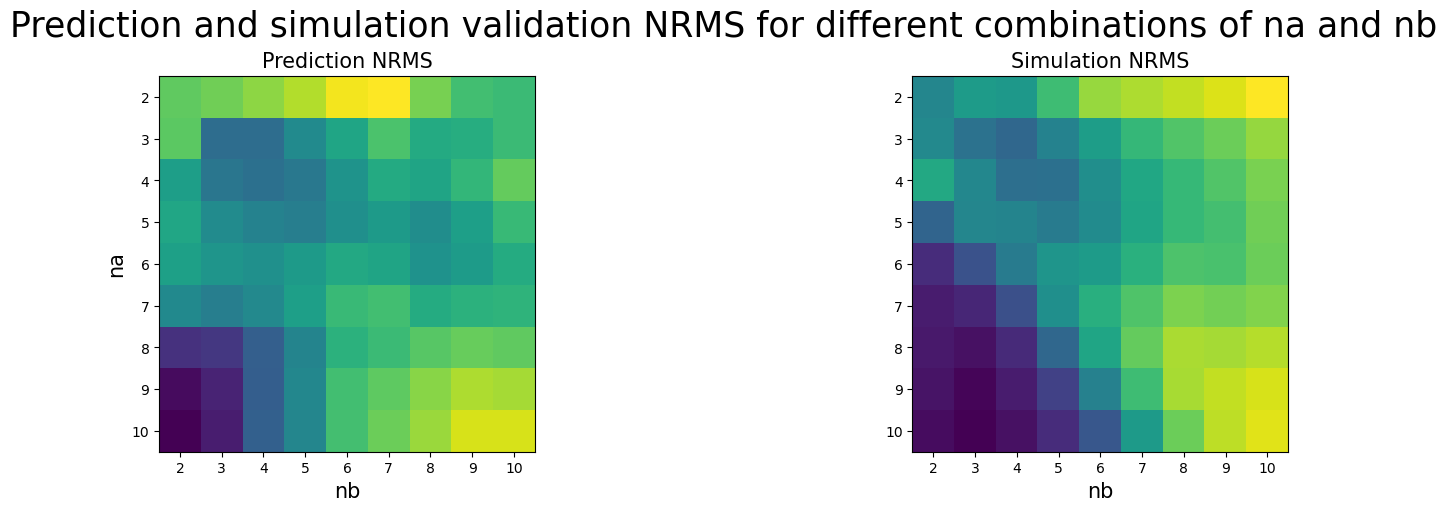

In [9]:
# Plot results for validation data
fs=15
fig = plt.figure(figsize=(15, 5),layout='constrained')
ax1=fig.add_subplot(121)
ax1.imshow(val_pred_NRMSs, interpolation='none', norm='log')
ax2=fig.add_subplot(122)
ax2.imshow(val_sim_NRMSs, interpolation='none', norm='log')
ax1.set_title('Prediction NRMS',fontsize=fs)
ax2.set_title('Simulation NRMS',fontsize=fs)
fig.suptitle('Prediction and simulation validation NRMS for different combinations of na and nb', fontsize=25)
ax1.set_ylabel('na',fontsize=fs)
ax1.set_xlabel('nb',fontsize=fs)
ax2.set_xlabel('nb',fontsize=fs)
ax1.set_yticklabels([0]+na_list)
ax1.set_xticks([*range(len(nb_list))],nb_list)
ax2.set_yticklabels([0]+na_list)
ax2.set_xticks([*range(len(nb_list))],nb_list)

params = np.zeros((len(na_list), len(nb_list), 2))
for i, n_a in enumerate(na_list):
    for j, n_b in enumerate(nb_list):
        params[i, j, :] = [n_a, n_b]

min_arg = np.unravel_index(val_pred_NRMSs.argmin(keepdims=True), val_pred_NRMSs.shape)
best_na, best_nb = params[min_arg].ravel()
print(f"Best parameters by prediction NRMS: na= {best_na}, nb= {best_nb}")

min_arg = np.unravel_index(val_sim_NRMSs.argmin(keepdims=True), val_sim_NRMSs.shape)
best_na, best_nb = params[min_arg].ravel()
print(f"Best parameters by simulation NRMS: na= {best_na}, nb= {best_nb}")

C:\Users\20193261\AppData\Local\Temp\ipykernel_18516\1844395562.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels([0]+na_list)
C:\Users\20193261\AppData\Local\Temp\ipykernel_18516\1844395562.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels([0]+na_list)


Best parameters by prediction NRMS: na= 7.0, nb= 3.0
Best parameters by simulation NRMS: na= 9.0, nb= 2.0


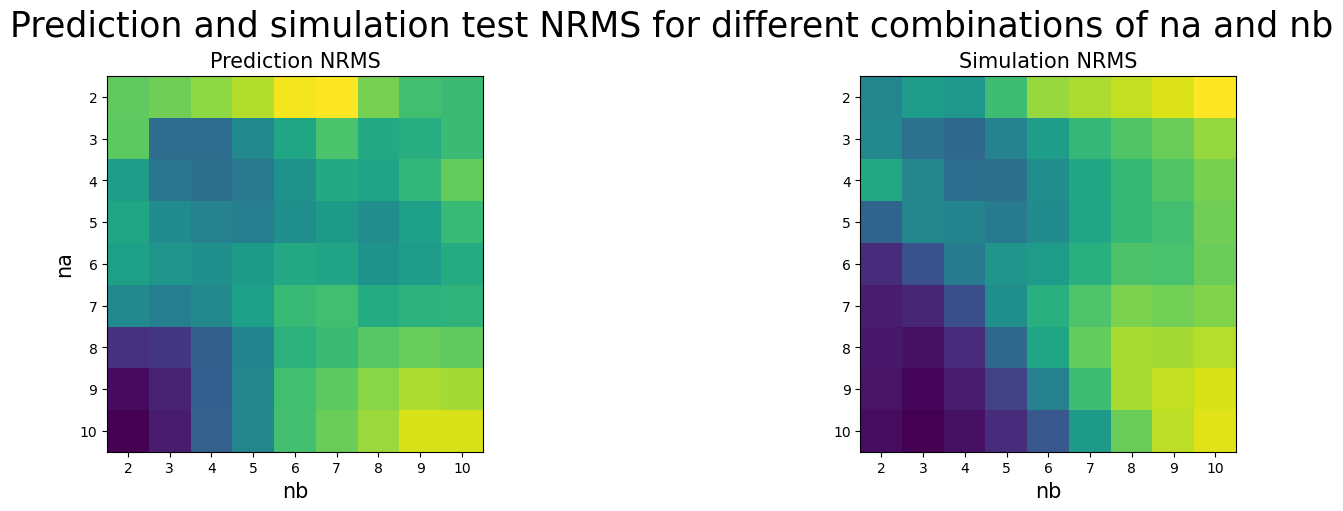

In [10]:
# Plot results for test data
fs=15
fig = plt.figure(figsize=(15, 5),layout='constrained')
ax1=fig.add_subplot(121)
ax1.imshow(val_pred_NRMSs, interpolation='none', norm='log')
ax2=fig.add_subplot(122)
ax2.imshow(val_sim_NRMSs, interpolation='none', norm='log')
ax1.set_title('Prediction NRMS',fontsize=fs)
ax2.set_title('Simulation NRMS',fontsize=fs)
fig.suptitle('Prediction and simulation test NRMS for different combinations of na and nb', fontsize=25)
ax1.set_ylabel('na',fontsize=fs)
ax1.set_xlabel('nb',fontsize=fs)
ax2.set_xlabel('nb',fontsize=fs)
ax1.set_yticklabels([0]+na_list)
ax1.set_xticks([*range(len(nb_list))],nb_list)
ax2.set_yticklabels([0]+na_list)
ax2.set_xticks([*range(len(nb_list))],nb_list)

params = np.zeros((len(na_list), len(nb_list), 2))
for i, n_a in enumerate(na_list):
    for j, n_b in enumerate(nb_list):
        params[i, j, :] = [n_a, n_b]

min_arg = np.unravel_index(test_pred_NRMSs.argmin(keepdims=True), test_pred_NRMSs.shape)
best_na, best_nb = params[min_arg].ravel()
print(f"Best parameters by prediction NRMS: na= {best_na}, nb= {best_nb}")

min_arg = np.unravel_index(test_sim_NRMSs.argmin(keepdims=True), test_sim_NRMSs.shape)
best_na, best_nb = params[min_arg].ravel()
print(f"Best parameters by simulation NRMS: na= {best_na}, nb= {best_nb}")

In [25]:
print(f"Best test simulation NRMS found: {test_sim_NRMSs[8, 1]}")

Best test simulation NRMS found: 0.30840117275649676


In [23]:
test_sim_NRMSs

array([[0.30976238, 0.31719125, 0.33650977, 0.35547425, 0.37749284,
        0.38185064, 0.38521773, 0.38351629, 0.38355275],
       [0.31252206, 0.31179472, 0.31881203, 0.33020706, 0.34621431,
        0.35218023, 0.35309621, 0.35363792, 0.35557015],
       [0.31570311, 0.31523788, 0.32113555, 0.32629369, 0.34158807,
        0.34921551, 0.3522087 , 0.35093691, 0.35204573],
       [0.30968458, 0.31373241, 0.32266099, 0.32765454, 0.34102526,
        0.34769916, 0.35151061, 0.35230194, 0.3544153 ],
       [0.30845112, 0.31200303, 0.32264001, 0.33019171, 0.34080105,
        0.34525239, 0.34757602, 0.34841712, 0.35187382],
       [0.30708075, 0.31041323, 0.32009595, 0.330634  , 0.34053156,
        0.34394758, 0.34422603, 0.34339408, 0.34483587],
       [0.30645908, 0.30949426, 0.31786463, 0.32858176, 0.33923561,
        0.34163235, 0.34176076, 0.34017746, 0.34000217],
       [0.3060128 , 0.30853851, 0.31590196, 0.32580826, 0.33616553,
        0.3388973 , 0.3394989 , 0.33810435, 0.33750273],
